In [115]:
import numpy as np
from sklearn.datasets import load_iris
from graphviz import Digraph

In [116]:
data = load_iris()
X = data.data
y = data.target

# Helper functions 

## Entropy
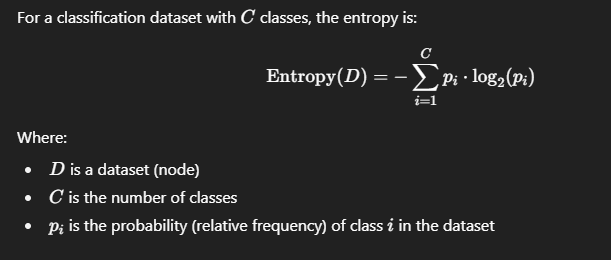

In [117]:
def entropy(y):
    cls, count = np.unique(y, return_counts = True)
    prob = count / len(y)
    entropy = -np.sum(prob * np.emath.log2(prob))
    return entropy   

## Information gain
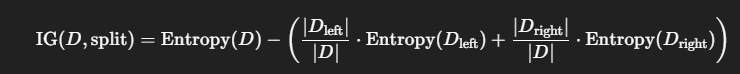

In [118]:
def info_gain(X , y):
    features = X.shape[1]

    best_ig = 0
    best_threshold = None
    best_feature = None
    
    parent_entropy = entropy(y)
    
    for feature in range(features):
        
        unique_vals = np.sort(np.unique(X[:, feature]))
        thresholds = (unique_vals[1:] + unique_vals[: -1]) / 2
        
        for thres in thresholds:
            left_mask  = X[: , feature] <= thres
            right_mask = X[: , feature] > thres

            y_left = y[left_mask]
            y_right = y[right_mask]
        
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            ig = parent_entropy - (((len(y_left)  / len(y)) * entropy(y_left)) + ((len(y_right)  / len(y)) * entropy(y_right)))

            if ig > best_ig:
                best_ig = ig
                best_threshold = thres
                best_feature = feature
    
    return best_ig , best_threshold , best_feature
    


## class for storing information

In [119]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        

## tree building through recursion

In [120]:
def build_tree(X , y, depth = 0, max_depth = None):
    if len(np.unique(y)) == 1:
        return Node(value = y[0])

    if max_depth is not None and depth >= max_depth:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)

    info, threshold, feature = info_gain(X, y)

    if info == 0:
        most_common = np.bincount(y).argmax()
        return Node(value = most_common)
    left_mask = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold

    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]

    left_node = build_tree( X_left, y_left , depth +1 , max_depth)
    right_node = build_tree( X_right, y_right , depth +1 , max_depth)

    return Node(
    feature=feature,
    threshold=threshold,
    left=left_node,
    right=right_node
    )

 

## MODEL CLASS

In [121]:
class DecisionTree:
    def __init__(self, max_depth = None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = build_tree(X, y, depth = 0, max_depth  = self.max_depth)

    def _traverse_tree (self, X, node):
        if node.value is not None:
            return node.value

        if X[node.feature] <= node.threshold:
            return self._traverse_tree(X, node.left)
        else:
            return self._traverse_tree(X, node.right)
            
    def predict_one(self, X):
        return self._traverse_tree (X, self.root)
    
    def predict(self, X):
        return np.array([self.predict_one(i) for i in X])


## utility functions 

In [122]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y

def accuracy(y_true, y_pred):
        return np.mean(y_true == y_pred)

# Model execution

In [132]:
train_X, train_y, test_X, test_y = train_test_split(X, y, ratio = 0.7 , shuffle = True, seed = 1)

model = DecisionTree()
model.fit(train_X, train_y)


# Tree visualization

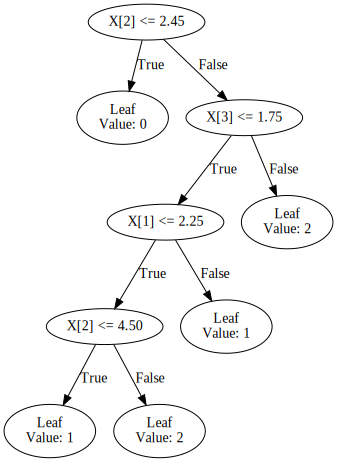

In [133]:
def visualize_tree(node, dot = None, counter = [0]):
    if dot == None:
        dot = Digraph()
        dot.attr('node' , shape = 'box')

    current_id = str(counter[0])
    counter[0] += 1
    
    if node.value is not None:
        dot.node(current_id , f'Leaf \n Value: {node.value}')
        
    else:
        dot.node(current_id, f'X[{node.feature}] <= {node.threshold:.2f}')

        left_id = visualize_tree(node.left, dot, counter)
        right_id = visualize_tree(node.right, dot, counter)

        dot.edge(current_id, left_id, label='True')
        dot.edge(current_id, right_id, label='False')

    return current_id 
    
dot = Digraph()
visualize_tree(model.root, dot)
dot

In [134]:
y_pred = model.predict(test_X)
print('Accuracy:', accuracy(test_y, y_pred))

Accuracy: 0.8888888888888888
